In [1]:
import numpy as np

dataset = np.array([0,1,2,3,4,5,6,7,8,9])
split = int(0.2 * len(dataset))
indices = np.random.choice(len(dataset), size=split, replace=False)

# train_set = dataset[~np.isin(np.arange(len(dataset)), indices)]
# test_set = dataset[indices]

train_indices = list(set(range(len(dataset))) - set(indices))
train_set = [dataset[i] for i in train_indices]
test_set = [dataset[i] for i in indices]

print("Train set:", train_set)
print("Test set:", test_set)

# Simulate dataset growth
dataset = np.append(dataset, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

# Adjust indices for the larger dataset
split = int(0.2 * len(dataset))
existing = set(indices)
needed = split - len(indices)
if needed > 0:
    available = list(set(range(len(dataset))) - existing)
    indices = np.concatenate([indices, np.random.choice(available, size=needed, replace=False)])

train_indices = list(set(range(len(dataset))) - set(indices))
train_set = [dataset[i] for i in train_indices]
test_set = [dataset[i] for i in indices]

# train_set = dataset[~np.isin(np.arange(len(dataset)), indices)]
# test_set = dataset[indices]

print("Train set:", train_set)
print("Test set:", test_set)

Train set: [1, 2, 3, 4, 5, 7, 8, 9]
Test set: [0, 6]
Train set: [1, 2, 3, 4, 5, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Test set: [0, 6, 10, 9]


# softmax

In [5]:
tmp = [
        [ 1.3933e+00, -1.7888e+00],
        [ 1.1982e+00, -1.5443e+00],
        [ 4.4996e-01, -6.3498e-01],
        [ 8.3737e-01, -1.1116e+00],
        [-1.4096e-01,  8.7677e-02],
        [ 7.0414e-01, -9.0529e-01],
        [ 1.3783e-01, -2.4636e-01],
        [ 7.9157e-01, -1.0170e+00],
        [ 6.2291e-01, -8.0565e-01],
        [-1.2596e-01,  7.4609e-02],
        [ 2.0108e-01, -3.1999e-01],
        [-2.9866e-01,  2.9349e-01],
        [ 5.8798e-01, -7.6095e-01],
        [-6.2754e-02,  9.0338e-04],
        [-4.9592e-01,  5.3039e-01],
        [-4.3970e-01,  4.6003e-01]]

import torch.nn.functional as F
import torch
probs = F.softmax(torch.tensor((tmp), dtype=torch.float32), dim=1)
probs

tensor([[0.9602, 0.0398],
        [0.9395, 0.0605],
        [0.7474, 0.2526],
        [0.8753, 0.1247],
        [0.4431, 0.5569],
        [0.8333, 0.1667],
        [0.5949, 0.4051],
        [0.8592, 0.1408],
        [0.8067, 0.1933],
        [0.4500, 0.5500],
        [0.6274, 0.3726],
        [0.3561, 0.6439],
        [0.7940, 0.2060],
        [0.4841, 0.5159],
        [0.2638, 0.7362],
        [0.2891, 0.7109]])

# WeightedRandomSampler

In [19]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import pickle
import numpy as np

class OfflineDataset(Dataset):
    def __init__(self, filename):
        self.experiences = pickle.load(open(filename,'rb'))
        self.priorities = np.ones(len(self.experiences), dtype=np.float32)
    def __len__(self):
        return len(self.experiences)
    def __getitem__(self, idx):
        return self.experiences[idx]

# 2) Write a trivial collate_fn that just zips your list of 7-tuples
def collate_fn(batch):
    # batch is List[ Tuple7 ], we want Tuple7 of Lists
    return tuple( list(x) for x in zip(*batch) )

# 3) Create your DataLoader with sampler + collate_fn
dataset = OfflineDataset("results/warehouse_2_dataset/dataset.pkl")
weights = dataset.priorities + 1e-8
sampler = WeightedRandomSampler(weights, num_samples=len(dataset), replacement=True)
loader  = DataLoader(
    dataset,
    batch_size=2,
    sampler=sampler,
    collate_fn=collate_fn,
    pin_memory=True,
)


In [20]:
# 4) Now iterate without KeyErrors:
for obs_fovs, partial_prio, global_reward, local_rewards, groups, starts, goals in loader:
    # obs_fovs: List[Tensor] of length batch_size
    # partial_prio: List[dict]   ...
    # global_reward: List[float]
    # ...
    # convert global_reward to a tensor
    # global_reward = torch.tensor(global_reward, dtype=torch.float32, device=device)
    # and so on—pass these batches to trainer.optimize()

    print(len(obs_fovs))
    print(obs_fovs[0].shape)
    break

2
torch.Size([70, 8, 11, 11])


In [ ]:
# ---- 4. Training Loop ----
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in loader:
        # Unpack the batch of experiences
        obs_fovs, partial_prio, global_reward, local_rewards, groups, starts, goals = zip(*batch)

        # Convert global_reward list to tensor
        global_reward = torch.tensor(global_reward, dtype=torch.float32, device=trainer.device)

        # Zero out gradients
        optimizer.zero_grad()

        # Perform one training step: returns total loss and per-experience TD errors
        loss, td_errors = trainer.optimize(
            obs_fovs, partial_prio, global_reward,
            local_rewards, groups, starts, goals
        )

        # Backpropagate and update weights
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}")

    # Optionally update sampler weights with new td_errors:
    # e.g. dataset.priorities[...] = updated_priorities_based_on(td_errors)
    # sampler.weights = dataset.priorities  # if your sampler supports dynamic updates

# Torchviz model visualization

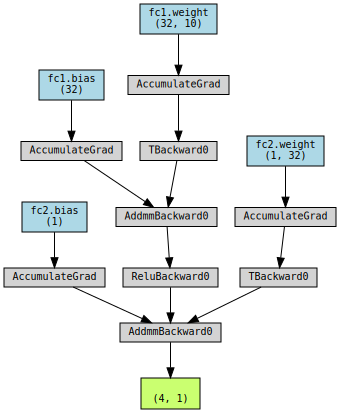

In [3]:
from Model import QNetwork, QJoint, VJoint

import torchviz
import torch
import torch.nn as nn

from torchviz import make_dot

class TinyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x)))

net = TinyNet()
x   = torch.randn(4, 10)

y = net(x)               # forward pass

make_dot(y, params=dict(net.named_parameters()))

# dot = make_dot(y, params=dict(net.named_parameters()))
# dot.render('tinynet', format='pdf')

In [4]:
import torch

torch.tensor([1.6215e-03, 7.8728e-04, 2.0838e-04, 1.6530e-03, 1.2689e-03, 1.2745e-03,
        3.3193e-02, 7.8310e-06, 1.5021e-04, 6.5385e-04, 5.0044e-04, 7.1709e-04,
        3.3469e-03, 4.1206e-03, 3.8412e-04, 4.5285e-04, 6.4665e-04, 4.7792e-03,
        1.2347e-04, 7.2960e-04, 3.6799e-02, 2.3749e-03, 1.7622e-03, 3.1194e-05,
        5.4498e-05, 2.0804e-04, 2.2076e-04, 1.2804e-04, 3.9369e-04, 5.8473e-03,
        1.6181e-04, 9.2504e-05, 1.6354e-03, 8.2326e-04, 5.6677e-03, 1.0392e-05,
        9.4922e-04, 1.3039e-03, 4.9219e-03, 1.3035e-03, 8.7323e-04, 7.8713e-05,
        1.8638e-01, 1.7150e-04, 1.0938e-04, 2.3190e-05, 3.4293e-04, 9.8049e-04,
        4.6360e-05, 5.1330e-03, 9.5188e-06, 3.3497e-04, 1.5156e-04, 6.2671e-05,
        7.0613e-04, 6.9807e-05, 2.4396e-01, 1.8623e-04, 7.4531e-03, 1.3471e-04,
        1.1687e-04, 1.4703e-04, 6.0240e-04, 2.9773e-04]).mean().item()

0.008901250548660755

In [ ]:
l = [[(0, 1), (2, 3)], [(0, 1)], [(0, 1), (0, 3)], [(0, 3), (1, 2), (2, 3)], [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)], [(0, 2), (2, 3)], [(0, 2)], [(0, 1), (0, 2), (1, 2)], [(0, 1), (0, 2), (0, 3), (2, 3)], [(0, 2), (0, 3), (2, 3)], [(0, 3), (2, 3)], [(0, 1), (0, 3), (1, 2), (2, 3)], [(0, 2), (1, 3), (2, 3)], [(1, 2), (1, 3), (2, 3)], [(0, 2), (0, 3), (2, 3)], [(0, 1), (0, 3), (1, 3)], [(0, 2), (0, 3), (2, 3)], [(0, 1), (0, 3), (1, 2), (1, 3), (2, 3)], [(0, 1), (0, 2)], [(0, 1), (0, 3), (1, 3)], [(0, 2)], [(0, 1), (0, 3), (1, 3)], [(0, 2)], [(0, 1), (1, 2), (1, 3)], [(0, 1), (0, 3), (1, 3)], [(0, 1), (0, 2), (1, 2)], [(0, 1), (0, 3)], [(1, 3), (2, 3)], [(0, 2)], [(0, 2), (1, 2), (1, 3)], [(0, 3)], [(0, 1), (0, 3), (1, 3)], [(0, 2), (1, 2), (2, 3)], [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)], [(0, 3), (1, 3), (2, 3)], [(0, 2)], [(0, 2), (2, 3)], [(0, 3), (1, 2), (1, 3), (2, 3)], [(0, 2), (1, 3)], [(0, 2)], [(0, 2), (1, 3)], [(0, 1), (2, 3)], [(0, 2)], [(1, 3)], [(0, 1), (0, 3), (1, 3)], [(2, 3)], [(0, 1), (0, 3), (1, 3)], [(0, 2), (0, 3), (1, 3)], [(0, 1), (0, 2), (0, 3), (2, 3)], [(0, 1), (0, 3), (2, 3)], [(0, 1), (1, 3)], [(0, 2), (0, 3), (2, 3)], [(0, 3)], [(0, 1), (0, 3), (1, 3)], [(0, 1)], [(0, 2), (0, 3), (1, 3)], [(0, 2)], [(0, 1), (0, 3), (1, 3)], [(0, 3)], [(0, 3), (1, 2)], [(0, 1), (0, 3), (1, 3)], [(0, 2)], [(0, 2)], [(0, 2), (1, 3)]]

l = [[(1, 3)], [(0, 2), (0, 3), (1, 2), (1, 3), (2, 3)], [(0, 1), (0, 2), (1, 2)], [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3)], [(0, 1), (0, 2), (1, 2)], [(1, 2), (1, 3), (2, 3)], [(0, 2), (0, 3), (2, 3)], [(0, 1), (1, 2)], [(0, 2), (0, 3), (2, 3)], [(0, 1), (0, 2), (0, 3), (2, 3)], [(0, 1), (0, 3), (1, 3)], [(0, 2)], [(0, 1), (0, 2), (1, 2)], [(0, 2), (1, 2), (1, 3), (2, 3)], [(0, 2), (1, 3), (2, 3)], [(0, 1), (1, 3)], [(0, 1), (1, 2), (2, 3)], [(1, 2), (2, 3)], [(0, 1), (0, 2), (0, 3), (2, 3)], [(0, 2), (0, 3), (2, 3)], [(0, 2), (1, 2), (1, 3)], [(0, 2), (0, 3), (2, 3)], [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)], [(0, 2), (1, 3)], [(1, 3)], [(0, 2)], [(0, 3)], [(0, 2), (1, 3)], [(0, 1), (0, 3)], [(0, 2), (0, 3), (1, 3)], [(0, 1), (0, 3), (1, 3)], [(0, 2), (0, 3), (2, 3)], [(0, 1), (0, 3), (1, 3)], [(0, 3), (1, 2), (1, 3), (2, 3)], [(0, 2), (1, 3), (2, 3)], [(0, 2), (1, 2)], [(0, 2), (0, 3), (2, 3)], [(1, 2)], [(1, 3)], [(0, 1), (0, 3), (1, 3)], [(0, 1)], [(0, 2), (0, 3), (2, 3)], [(0, 3), (1, 3), (2, 3)], [(0, 2), (0, 3), (1, 3)], [(1, 3)], [(0, 1), (0, 2), (1, 2)], [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)], [(1, 3)], [(0, 2)], [(0, 2), (1, 2), (2, 3)], [(0, 1)], [(1, 3), (2, 3)], [(0, 1), (0, 2), (0, 3), (1, 3)], [(0, 2), (1, 2)], [(1, 3)], [(1, 3)], [(0, 1), (0, 3)], [(0, 1), (0, 3), (1, 3), (2, 3)], [(0, 2)], [(1, 2), (1, 3), (2, 3)], [(0, 1), (0, 3), (1, 3)], [(0, 1), (1, 3)], [(0, 1)], [(2, 3)]]


a = [9.1245e-01, 1.9262e-01, 4.3413e-01, 3.8246e-02, 2.1867e-03, 1.6926e-03,
        3.6877e-01, 2.2714e-03, 7.7246e-02, 3.2194e-03, 4.2293e-03, 2.4331e-04,
        1.3856e-03, 3.6741e-03, 3.9936e-03, 2.6778e-04, 2.2501e-03, 6.7847e-04,
        1.7837e-03, 2.1011e-03, 4.4006e-04, 3.1042e-03, 1.3288e-03, 2.5307e-03,
        3.4388e-04, 1.2259e-04, 9.5112e-06, 1.1028e-03, 2.6658e-03, 4.7333e-09,
        4.4354e-03, 4.8724e-03, 2.0503e-03, 2.2462e-03, 5.8101e-03, 4.2945e-03,
        3.0568e-03, 7.9313e-04, 1.9873e-03, 1.8343e-03, 2.1070e-03, 4.9566e-06,
        1.9166e-03, 4.4622e-03, 2.9902e-03, 4.6010e-03, 1.5927e-04, 4.8424e-03,
        4.3561e-03, 1.1414e-03, 1.7169e-06, 3.1846e-03, 2.1972e-03, 1.0080e-03,
        1.8267e-03, 4.7542e-03, 1.0403e-04, 1.0705e-04, 2.5865e-03, 2.0412e-03,
        4.1759e-04, 2.1627e-03, 4.2128e-03, 2.8076e-03, 1.3216e-03, 7.1762e-04]
b = [9.1245e-01, 1.9262e-01, 4.3413e-01, 3.8246e-02, 2.1867e-03, 1.6926e-03,
        3.6877e-01, 2.2714e-03, 7.7246e-02, 3.2194e-03, 4.2293e-03, 2.4331e-04,
        1.3856e-03, 3.6741e-03, 3.9936e-03, 2.6778e-04, 2.2501e-03, 6.7847e-04,
        1.7837e-03, 2.1011e-03, 4.4006e-04, 3.1042e-03, 1.3288e-03, 1.4373e-03,
        1.2259e-04, 9.5112e-06, 1.1028e-03, 1.3329e-03, 4.4354e-03, 4.8724e-03,
        2.0503e-03, 2.2462e-03, 5.8101e-03, 4.2945e-03, 3.0568e-03, 7.9313e-04,
        1.9873e-03, 1.8343e-03, 2.1070e-03, 4.9566e-06, 1.9166e-03, 4.4622e-03,
        2.9902e-03, 4.6010e-03, 1.5927e-04, 4.8424e-03, 4.3561e-03, 1.1414e-03,
        1.7169e-06, 3.1846e-03, 2.1972e-03, 1.0080e-03, 1.8267e-03, 4.7542e-03,
        1.0403e-04, 1.0705e-04, 2.5865e-03, 2.0412e-03, 4.1759e-04, 2.1627e-03,
        4.2128e-03, 2.8076e-03, 1.3216e-03, 7.1762e-04]

print(len(a), len(b))

for i, j in zip (a, b):
    if i != j:
        print(i, j)


In [ ]:
rewards = (
([-0.2], [-1.2, -0.2], [-0.2], [-0.2, -0.2], [-0.2, -0.2], [-0.2], [-0.2], [-0.2], [-0.2], [-0.2, -0.2], [-0.2], [-0.2, -0.2], [-0.7], [-0.2], [-0.2], [-1.45], [-0.2], [-0.2], [-0.2], [-0.2], [-0.2], [-0.2], [-0.2], [-0.2], [-0.2], [-1.2], [-1.5333333333333332], [-0.2, -0.2], [-0.2], [-0.2], [-0.2], [-0.2], [-0.2, -0.2], [-0.8666666666666667], [-0.2], [-0.8666666666666667], [-0.8666666666666667], [-0.2], [-0.2], [-0.7], [-0.2], [-0.2], [-0.7], [-0.2], [-0.2, -0.2], [-0.2], [-0.2], [-0.2], [-0.2], [-0.2], [-0.2], [-0.2], [-1.2, -0.2], [-0.2], [-0.2], [-0.2], [-0.2], [-0.2, -0.2], [-0.7], [-0.2], [-1.2, -0.2], [-0.2], [-0.7], [-0.2])
    )


# qjt predicted
qjt = [[[-0.159, -0.213, -0.189]], [[-0.743], [-0.218]], [[-0.282, -0.183]], [[-0.265], [-0.308]], [[-0.206], [-0.334]], [[-0.181, -0.331]], [[-0.319]], [[-0.227, -0.19, -0.237, -0.291]], [[-0.157, -0.189, -0.135, -0.187, -0.192]], [[-0.198], [-0.26]], [[-0.168, -0.301]], [[-0.273], [-0.356]], [[-0.516, -0.586, -0.577, -0.567]], [[-0.214, -0.272, -0.234]], [[-0.223]], [[-1.394, -1.319, -1.471, -1.293, -1.431, -1.46]], [[-0.249, -0.245, -0.208]], [[-0.181, -0.28, -0.324]], [[-0.167]], [[-0.238, -0.16]], [[-0.217, -0.225, -0.271]], [[-0.17, -0.355, -0.232, -0.259]], [[-0.27, -0.233]], [[-0.22]], [[-0.221, -0.199, -0.217, -0.203, -0.11, -0.081]], [[-0.955]], [[-1.517, -1.395, -1.48]], [[-0.27], [-0.191]], [[-0.192, -0.224, -0.196, -0.138, -0.175, -0.278]], [[-0.112, -0.199]], [[-0.246, -0.22]], [[-0.252, -0.178]], [[-0.254], [-0.265]], [[-0.946, -0.986]], [[-0.279, -0.157, -0.158]], [[-0.846, -0.658, -0.933]], [[-0.843, -0.915, -0.899]], [[-0.228, -0.289, -0.196]], [[-0.155, -0.215, -0.108]], [[-0.646, -0.848, -0.549, -0.872, -0.788]], [[-0.216, -0.172]], [[-0.163, -0.159, -0.17]], [[-0.591, -0.556, -0.588, -0.595, -0.613, -0.574]], [[-0.241, -0.16, -0.23]], [[-0.31], [-0.172]], [[-0.173, -0.185, -0.183, -0.168, -0.123, -0.201]], [[-0.2, -0.349, -0.224]], [[-0.331, -0.203]], [[-0.203, -0.323, -0.188]], [[-0.254, -0.194, -0.149]], [[-0.227, -0.232, -0.23]], [[-0.36, -0.426, -0.352]], [[-1.039], [-0.195]], [[-0.224, -0.266, -0.304]], [[-0.299, -0.29, -0.19, -0.209]], [[-0.223, -0.144]], [[-0.208, -0.2, -0.216, -0.157, -0.145, -0.242]], [[-0.353], [-0.202]], [[-0.544, -0.593, -0.663, -0.633, -0.595, -0.635]], [[-0.196, -0.23, -0.175]], [[-0.826], [-0.254]], [[-0.191, -0.155, -0.201]], [[-0.639, -0.546, -0.484, -0.579]], [[-0.205, -0.283]]]

for q, r in zip(qjt, rewards):
    print(q, "---------------------", r)

In [ ]:
import numpy as np

heuri_map = np.array(
    [
        [
            [
                [0.1, 0.2, 0.3, 0.4, 0.5],
                [0.6, 0.7, 0.8, 0.9, 1.0],
                [1.1, 1.2, 1.3, 1.4, 1.5],
                [1.6, 1.7, 1.8, 1.9, 2.0],
                [2.1, 2.2, 2.3, 2.4, 2.5]
            ]
            
        ],
        
     ]
)
obs_radius = 7

heuri_map = np.pad(heuri_map, ((0, 0), (0, 0), (obs_radius, obs_radius), (obs_radius, obs_radius)))
heuri_map

In [1]:
import copy
import time
import yaml
import os
import shutil

from utils import *                   # Custom utility functions and classes
from Environment import Environment    # Environment setup class

# Set global numpy seed for reproducibility
np.random.seed(0)

config_name = "warehouse_2"

# Load configuration file
file_path = "config.yaml"
with open(file_path, "r") as file:
    config_file = yaml.safe_load(file)

config = config_file[config_name]

# Environment Configuration
env_config = config["environment"]

# Training Configuration
train_config   = config["training"]
OVERFIT_TEST   = train_config["OVERFIT_TEST"]
BATCH_SIZE     = train_config["BATCH_SIZE"]
LAMBDA         = train_config["LAMBDA"]
LR             = float(train_config["LR"])
BUFFER_SIZE    = train_config["BUFFER_SIZE"]
TRAIN_STEPS    = float(train_config["TRAIN_STEPS"])  # Convert to int for loops
N_ACTIONS      = train_config["N_ACTIONS"]

# Paths Configuration
paths_config      = config["paths"]
GRID_MAP_FILE     = paths_config["map_file"]
HEURISTIC_MAP_FILE= paths_config["heur_file"]
DIR               = config["root"] + paths_config["results"]
saved_model_path  = os.path.join(DIR, 'q_net_model/')
log_path          = os.path.join(DIR, "log/")

# Use QTRAN alternative version flag
is_QTRAN_alt = True

# %% LOGGER & ENVIRONMENT INITIALIZATION
logger = Logger(os.path.join(log_path, "log.txt"))

env = Environment(env_config,
                  logger=logger,
                  grid_map_file=GRID_MAP_FILE,
                  heuristic_map_file=HEURISTIC_MAP_FILE,
                  start_loc_options=None,
                  goal_loc_options=None)

/localhome/esa95/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Environment.__init__: loading heuristic map from file


In [13]:
def get_close_pairs(num_agents, starts, heuristic_map, window_size):
    close_pairs = []
    for agent in range(num_agents):
        for neighbor in _get_neighboring_agents(agent, starts, heuristic_map, window_size, num_agents=num_agents):
            if neighbor > agent:
                close_pairs.append((agent, neighbor))
    return close_pairs

def _get_neighboring_agents(agent, starts, heuristic_map, window_size, num_agents):
    neighbors = []
    for a in range(num_agents):
        if a == agent:
            continue
        x, y = starts[a]
        i, j = starts[agent]
        if heuristic_map[(x, y)][i, j] <= window_size*2:
            neighbors.append(a)
    return neighbors

def _get_DHC_heur_to_goal(goal, grid_map, heuristic_map):
    heur = np.zeros((4, *grid_map.shape))
    heur_map = heuristic_map[goal]
    for y in range(grid_map.shape[0]):
        for x in range(grid_map.shape[1]):
            if grid_map[y, x] == 0:
                # up
                if y > 0 and heur_map[y-1, x] < heur_map[y, x]:
                    assert heur_map[y-1, x] == heur_map[y, x]-1
                    heur[0, y, x] = 1
                # down
                if y < grid_map.shape[0]-1 and heur_map[y+1, x] < heur_map[y, x]:
                    assert heur_map[y+1, x] == heur_map[y, x]-1
                    heur[1, y, x] = 1
                # left
                if x > 0 and heur_map[y, x-1] < heur_map[y, x]:
                    assert heur_map[y, x-1] == heur_map[y, x]-1
                    heur[2, y, x] = 1
                # right
                if x < grid_map.shape[0]-1 and heur_map[y, x+1] < heur_map[y, x]:
                    assert heur_map[y, x+1] == heur_map[y, x]-1
                    heur[3, y, x] = 1
    return heur

def _get_DHC_heur(num_agents, goals, grid_map, heuristic_map):
    # DHC HEURISTIC MAP
    DHC_heur = []
    for agent in range(num_agents):
        # number of goals, 4 directions, map size
        heur = np.zeros((len(goals[agent]), 4, *grid_map.shape))
        for i, goal in enumerate(goals[agent]):
            heur[i] = _get_DHC_heur_to_goal(goal, grid_map, heuristic_map)
        DHC_heur.append(heur)
    return DHC_heur

def _get_fov(grid_map, x, y, fov):
    max_val = np.max(grid_map)
    padded_grid = np.pad(grid_map, pad_width=fov//2, mode='constant', constant_values=0)
    return padded_grid[x:x+fov, y:y+fov]

def predict(starts, goals, window_size):
    num_agents = len(starts)

    grid_map = np.load('kiva.npy')
    heuristic_map = np.load('kiva_heur.npy', allow_pickle=True).item()

    size_x = grid_map.shape[1] - 2
    size_y = grid_map.shape[0] - 2

    print("size_x, size_y", size_x, size_y)

    row, col = grid_map.shape
    row = row - 2
    col = col - 2

    # revert from idx to coord
    # starts = [(start//col + 1, start%col + 1) for start in starts]
    # goals = [[(g[0]//col + 1, g[0]%col + 1) for g in goal] for goal in goals]

    # get close pairs
    close_pairs = get_close_pairs(num_agents, starts, heuristic_map, window_size)

    # get obs
    layers = 8
    fov = window_size * 2 + 1
    obs = np.zeros((num_agents, layers, fov, fov), dtype=np.float32)
    DHC_heur = _get_DHC_heur(num_agents, goals, grid_map, heuristic_map)

    for agent, (agent_pos, goal) in enumerate(zip(starts, goals)):
        x, y = agent_pos
        # 1. SURROUNDING OBSTACLES
        obs[agent, 0] = _get_fov(grid_map, x, y, fov)
        # 2. SURROUNDING AGENTS
        agent_map = np.zeros((grid_map.shape))
        arr = np.array(starts)
        agent_map[arr[:,0], arr[:,1]] = 1
        obs[agent, 1] = _get_fov(agent_map, x, y, fov)
        # 2. HEURISTIC TO GOAL
        # heur = _get_fov(heuristic_map[goal[0]], x, y, fov)
        padded_grid = np.pad(heuristic_map[goal[0]], pad_width=fov//2, mode='constant', constant_values=np.inf)
        heur = padded_grid[x:x+fov, y:y+fov]
        
        # normalize the heuristic map
        max_val = np.max(heur[heur < np.inf])
        obs[agent, 2] = heur / max_val

        # 3. DHC HEURISTIC LAYER
        obs[agent, 3] = _get_fov(DHC_heur[agent][0][0], x, y, fov)
        obs[agent, 4] = _get_fov(DHC_heur[agent][0][1], x, y, fov)
        obs[agent, 5] = _get_fov(DHC_heur[agent][0][2], x, y, fov)
        obs[agent, 6] = _get_fov(DHC_heur[agent][0][3], x, y, fov)

        normalized_coord = np.zeros((fov, fov))
        normalized_coord[0, 0] = y / size_x
        normalized_coord[0, 1] = x / size_y
        obs[agent, 7] = normalized_coord

    obs_fovs = torch.tensor(obs)
    obs_fovs = torch.where(torch.isinf(obs_fovs), torch.tensor(1), obs_fovs)

    return obs_fovs


starts, goals = env.starts, env.goals
window_size = 5

module_obs = predict(starts, goals, window_size)

size_x, size_y 46 33


In [12]:
env.size_x, env.size_y

(46, 33)

In [3]:
module_obs.shape

torch.Size([4, 8, 11, 11])

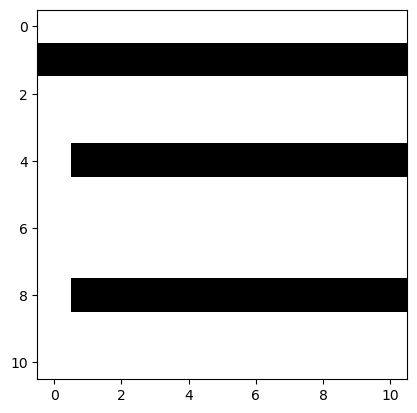

In [4]:
plt.imshow(module_obs[0][0], cmap='gray_r')

In [14]:
obs = env.get_obs()

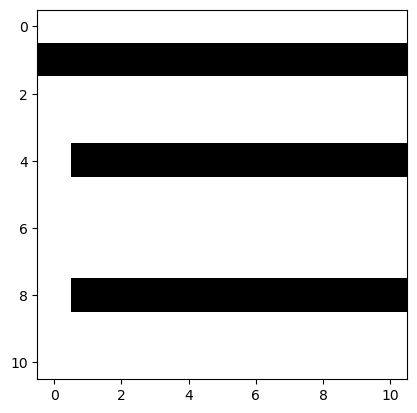

In [6]:
plt.imshow(obs[0][0], cmap='gray_r')

In [15]:
module_obs[0, 7, 0, 0:2], obs[0, 7, 0, 0:2]

(tensor([0.7391, 0.1212]), tensor([0.7391, 0.1212]))

In [16]:
# Boolean mask of mismatches
mismatch_mask = module_obs != obs

# Get indices where values differ
mismatch_indices = torch.nonzero(mismatch_mask, as_tuple=False)

print(mismatch_indices)

tensor([], size=(0, 4), dtype=torch.int64)


In [17]:
# Print the mismatched values
print("Mismatched values:")
for index in mismatch_indices:
    print(f"Index: {index}, Module Obs: {module_obs[index[0], index[1], index[2], index[3]]}, Env Obs: {obs[index[0], index[1], index[2], index[3]]}")

Mismatched values:


In [10]:
starts, goals = env.starts, env.goals

for agent, (agent_pos, goal) in enumerate(zip(starts, goals)):
    x, y = agent_pos
    heur = env._get_fov(env.heuristic_map[goal[0]], x, y, env.fov)

    # normalize the heuristic map
    max_val = np.max(heur[heur < np.inf])
    heur = heur / max_val
    heur = torch.tensor(heur)
    heur = torch.where(torch.isinf(heur), torch.tensor(1), heur)
    break

plt.imshow(heur, cmap="gray_r")
print(heur)

In [ ]:
import matplotlib.pyplot as plt
import torch

starts, goals = env.starts, env.goals

for agent, (agent_pos, goal) in enumerate(zip(starts, goals)):
    x, y = agent_pos
    heur = env._get_fov(env.heuristic_map[goal[0]], x, y, env.fov)
    padded_grid = np.pad(env.heuristic_map[goal[0]], pad_width=env.fov//2, mode='constant', constant_values=np.inf)
    heur = padded_grid[x:x+env.fov, y:y+env.fov]
    # normalize the heuristic map
    max_val = np.max(heur[heur < np.inf])
    heur = heur / max_val
    heur = torch.tensor(heur)
    heur = torch.where(torch.isinf(heur), torch.tensor(1), heur)

    break

plt.imshow(heur, cmap="gray_r")
print(heur)

# obs = env.get_obs()

# for i in range(len(obs[0])):
    # print(obs[0][i])

# plt.imshow(obs[1][2], cmap="gray_r")
# print(obs[1][2])

# env.get_obs().shape

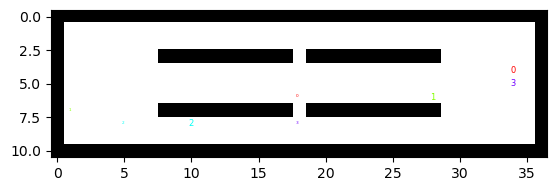

In [6]:
env.show_current_state()

In [31]:
from collections import defaultdict, deque
import random

def topological_sort_pbs(graph):
    """Topological sort on a directed graph."""
    in_degree = {node: 0 for node in graph}
    # randomize the order of nodes to ensure a unique topological sort
    random_order = list(graph.keys())
    random.shuffle(random_order)

    for node in graph:
        for neighbor in graph[node]:
            in_degree[neighbor] += 1

    zero_in_degree = deque([node for node in random_order if in_degree[node] == 0])
    print(zero_in_degree)
    sorted_order = []

    while zero_in_degree:
        current = zero_in_degree.popleft()
        sorted_order.append(current)
        for neighbor in graph[current]:
            in_degree[neighbor] -= 1
            if in_degree[neighbor] == 0:
                zero_in_degree.append(neighbor)

    if len(sorted_order) == len(graph):
        return sorted_order
    else:
        raise ValueError("Graph has a cycle and cannot be topologically sorted.")

# Define the priority order for the agents
priority_order = [
    (0, 1)
]

graph = defaultdict(list)
for agent in range(12):
    graph[agent] = []
for a, b in priority_order:
    graph[a].append(b)

priorities = topological_sort_pbs(graph)
priorities

deque([8, 11, 2, 3, 6, 9, 7, 0, 5, 10, 4])


[8, 11, 2, 3, 6, 9, 7, 0, 5, 10, 4, 1]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Example Q values and rewards
# Replace with your actual `selected_Q` and `batch_local_rewards`
selected_Q = torch.randn(64, 1) * 5  # fake predictions
batch_local_rewards = torch.randn(64) * 5  # fake targets
targets = batch_local_rewards.unsqueeze(1)

# Try different delta values
deltas = [0.5, 1.0, 2.0, 5.0]
losses = {}

for delta in deltas:
    loss = F.huber_loss(selected_Q, targets, delta=delta, reduction='none')
    losses[delta] = loss.detach().cpu().numpy().flatten()

    # huber_loss = nn.SmoothL1Loss(beta=delta, reduction='none')
    # losses[delta] = huber_loss(selected_Q, targets).detach().cpu().numpy().flatten()


# Plot the Huber loss for each delta
plt.figure(figsize=(8, 5))
for delta in deltas:
    plt.plot(losses[delta], label=f'delta = {delta}')
plt.xlabel('Sample index')
plt.ylabel('Huber Loss')
plt.title('Huber Loss per Sample for Different Delta Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


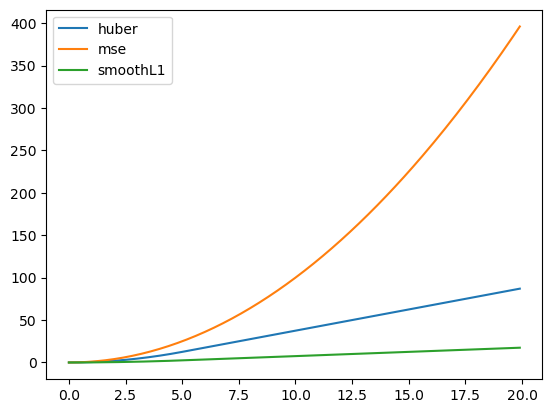

In [69]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

x_list = list(np.arange(0, 20, 0.1))

x = torch.tensor(x_list, dtype=torch.float32)
y = torch.tensor([0]*len(x_list), dtype=torch.float32)

smoothL1 = nn.SmoothL1Loss(beta=5, reduction='none')
loss_smoothL1 = smoothL1(x, y)

loss_huber = F.huber_loss(x, y, delta=5, reduction='none')
loss_mse = F.mse_loss(x, y, reduction='none')

plt.plot(x_list, loss_huber.detach().numpy(), label='huber')
plt.plot(x_list, loss_mse.detach().numpy(), label='mse')
plt.plot(x_list, loss_smoothL1.detach().numpy(), label='smoothL1')
plt.legend()

In [9]:
delays = [0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 5, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 1, 5, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 3, 0, 0, 0, 2, 0, 2, 0, 0, 1]

groups = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], [43, 101]]

local_rewards = []

# Calculate average local rewards for each group
for group in groups:
    local_rewards.append(0)
    for agent in group:
        local_rewards[-1] += delays[agent]
    # local_rewards[-1] /= len(group)

local_rewards

[55, 1]

In [8]:
class SafeGraph:
    def __init__(self, n):
        self.n = n
        self.adj = {i: set() for i in range(n)}
        self.reach = {i: set() for i in range(n)}  # transitive closure approximation

    def add_edge(self, u, v):
        if u in self.reach[v]:  # would create a cycle
            return False

        # Add edge safely
        self.adj[u].add(v)

        # Update reachable sets
        # Everyone who can reach u now can also reach v and v's reachable
        for x in range(self.n):
            if u in self.reach[x]:
                self.reach[x].update(self.reach[v])
                self.reach[x].add(v)
        self.reach[u].update(self.reach[v])
        self.reach[u].add(v)
        return True


pair_qval = {
    (2, 0): 0.7,
    (0, 1): 0.6,
    (1, 2): 0.5,
}

graph = SafeGraph(3)

pairs_action = {}

for (u, v), q in sorted(pair_qval.items(), key=lambda x: -abs(x[1])):
    print(f"edge: {u, v}")
    if graph.add_edge(u, v):
        pairs_action[(min(u,v), max(u,v))] = 0 if u < v else 1
    elif graph.add_edge(v, u):
        print("flip")
        pairs_action[(min(u,v), max(u,v))] = 1 if u < v else 0

edge: (2, 0)
edge: (0, 1)
edge: (1, 2)
flip


In [9]:
pairs_action

{(0, 2): 1, (0, 1): 0, (1, 2): 1}

In [19]:
import random

random.random()

0.9858905983972717

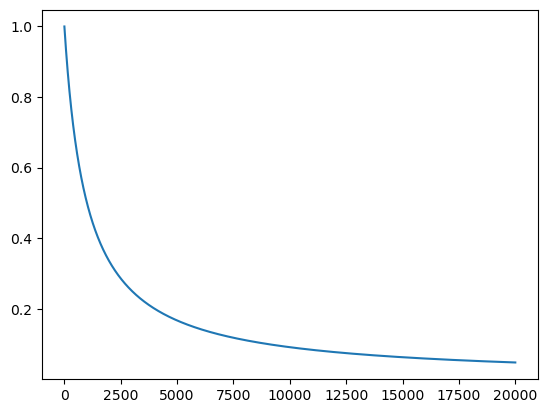

In [1]:
epsilon_start = 1.0
decay_rate = 1e-3

ep = []

for t in range(20000):
    epsilon = epsilon_start / (1 + decay_rate * t)
    ep.append(epsilon)

import matplotlib.pyplot as plt
plt.plot(ep)

In [40]:
print(batch_obs[:, :, :-1].shape, torch.tensor([tuple(zip(obs[:, -1, 0, 0], obs[:, -1, 0, 1])) for obs in batch_obs]).shape)

batch_coordinates = torch.tensor([tuple(zip(obs[:, -1, 0, 0], obs[:, -1, 0, 1])) for obs in batch_obs])
tmp = []
for coords in batch_coordinates:
    for coord in coords:
        tmp.append(coord)
batch_coordinates = torch.stack(tmp)
batch_coordinates.shape

torch.Size([32, 25, 2, 7, 7]) torch.Size([32, 25, 2])


torch.Size([800, 2])

In [ ]:
import numpy as np
import torch

# b, n, c, h, w
# coords in channel 2
batch_obs = np.zeros((32, 25, 3, 7, 7))
batch_obs[0, 0, 2, 0, 0] = 1
batch_obs[0, 0, 2, 0, 1] = 2
batch_obs = torch.tensor(batch_obs)

coordinates = [tuple(zip(obs[:, -1, 0, 0], obs[:, -1, 0, 1])) for obs in batch_obs]
len(coordinates[0]), coordinates[0]

In [ ]:
goals = [[(343, 0)], [(530, 0)], [(910, 0)], [(356, 0)], [(354, 0)], [(1276, 0)], [(346, 0)], [(66, 0)], [(62, 0)], [(974, 0)], [(423, 0)], [(1348, 0)], [(167, 0)], [(1177, 0)], [(998, 0)], [(530, 0)], [(237, 0)], [(243, 0)], [(169, 0)], [(1174, 0)], [(801, 0)], [(61, 0)], [(1002, 0)], [(1350, 0)], [(607, 0)], [(1271, 0)], [(975, 0)], [(527, 0)], [(980, 0)], [(1276, 0)], [(1004, 0)], [(894, 0)], [(342, 0)], [(72, 0)], [(820, 0)], [(266, 0)], [(1355, 0)], [(1174, 0)], [(1434, 0)], [(1365, 0)], [(246, 0)], [(332, 0)], [(812, 0)], [(360, 0)], [(1080, 0)], [(1440, 0)], [(521, 0)], [(1264, 0)], [(1254, 0)], [(697, 0)], [(538, 0)], [(530, 0)], [(330, 0)], [(75, 0)], [(357, 0)], [(884, 0)], [(975, 0)], [(903, 0)], [(1358, 0)], [(54, 0)]]

col = 46
[[(g[0]//col + 1, g[0]%col + 1) for g in goal] for goal in goals]

In [10]:
row, col = [int(i) for i in "33,46".strip().split(',')]
row, col

"maps/kiva.map".split('.')[0]

'maps/kiva'

In [1]:
import torch
from Model import QNetwork

# Load your trained model
model = QNetwork()  # Replace with your actual model class
model.load_state_dict(torch.load('./results/warehouse/q_net_model/q_net_1420000.pth'))
# model.eval()

# Convert to TorchScript
scripted_model = torch.jit.script(model)

# Save the TorchScript model
scripted_model.save("model.pt")

In [1]:
x = [1,2,3]
x.pop(0)
print(x)

[2, 3]


In [7]:
import torch

x = torch.tensor([1])

y = torch.tensor(2)

stacked = torch.stack([x, y])

RuntimeError: stack expects each tensor to be equal size, but got [1] at entry 0 and [] at entry 1

In [ ]:
x = [1,2,3,4,5,6]

int(x.index(1) > x.index(2)), int(x.index(2) > x.index(1))

(0, 1)

# reward function

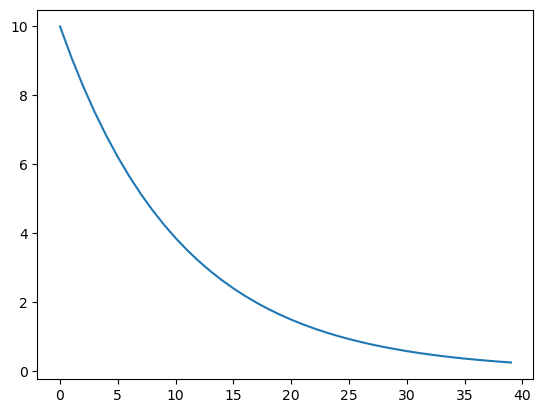

In [18]:
import numpy as np
import matplotlib.pyplot as plt


rew = range(40)
a = 1.1

# plot a^r
plt.plot([(a ** -r)*10 for r in rew])

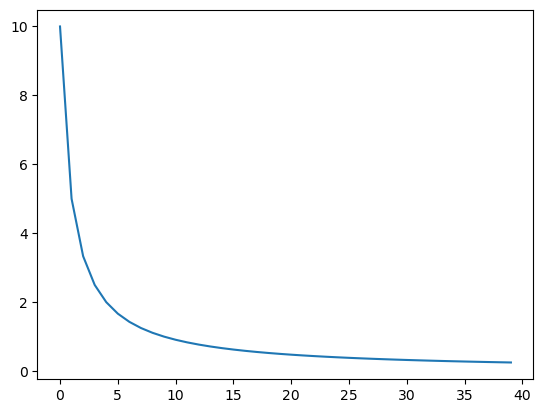

In [17]:
plt.plot([10 / (r + 1) for r in rew])

In [21]:
iterations = range(1000)
losses = [50 / (1 + 0.1*i) for i in iterations]  # example decreasing losses

plt.figure(figsize=(8, 5))
plt.plot(iterations, losses, label='Loss')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss Over Iterations')
plt.legend()
plt.show()

# saving files if dir does not exist yet

In [2]:
import numpy as np
import os

x = np.array([1, 2, 3, 4, 5])

# check if directory exists
if not os.path.exists('test/test1'):
    os.makedirs('test/test1')

if not os.path.exists('test/test1/x.npy'):
    np.save('test/test1/x.npy', x)

# Generate Warehouse map

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define the colormap
cmap = ListedColormap(["white", "black", "yellow", "red"])

In [129]:
def generate_warehouse(rows, cols, num_agents, num_goals, seed=None):
    np.random.seed(seed)

    people = np.array(
        [[2,2,0,2,2],
        [2,2,0,2,2],
        [2,2,0,2,2],
        ]
    )

    shelves = np.array(
        [[3]*10,
        [1]*10,
        [3]*10,
        ]
    )

    hall_ver = np.array(
        [[0],
        [0],
        [0],
        ]
    )

    row = people

    for j in range(cols):
        row = np.concatenate((row, hall_ver, shelves), axis=1)

    row = np.concatenate((row, hall_ver, people), axis=1)

    hall_hor = np.array(
        [[0]*len(row[0])]
    )

    warehouse = row

    for i in range(rows-1):
        warehouse = np.concatenate((warehouse, hall_hor, row), axis=0)

    # pad the warehouse with a row of zeros
    warehouse = np.pad(warehouse, 1, 'constant')

    plt.imshow(warehouse, cmap=cmap, vmin=0, vmax=3)


    # generate random starts and goals
    station_locs = np.where(warehouse == 2)
    station_locs = np.array(list(zip(station_locs[0], station_locs[1])))

    # get possible goal locations
    shelves_locs = np.where(warehouse == 3)
    shelves_locs = np.array(list(zip(shelves_locs[0], shelves_locs[1])))

    # generate randomly selected start and goal locations
    np.random.shuffle(station_locs)
    np.random.shuffle(shelves_locs)

    start_locs = station_locs[:num_agents]

    rng = np.random.default_rng()
    rng.shuffle(shelves_locs)
    goal_locs = np.array([[i] for i in shelves_locs[:num_agents].copy()])
    for i in range(num_goals):
        rng.shuffle(shelves_locs)
        new_shelves = shelves_locs[:num_agents].copy()
        goal_locs = np.concatenate((goal_locs, new_shelves[:, None, :]), axis=1)

    return warehouse, start_locs, goal_locs

In [134]:
ROWS = 4
COLS = 2

warehouse, start_locs, goal_locs = generate_warehouse(ROWS, COLS, num_agents=2, num_goals=15, seed=0)

# Softmax

In [20]:
import torch
import torch.nn.functional as F

import numpy as np

In [25]:
F.softmax(torch.tensor([[-0.039,  0.135],
[-0.215,  0.362],
[ 0.577, -0.623],
[-0.323,  0.443],
[ 0.473, -0.558],
[ 0.588, -0.609],
[-0.031, -0.095],
[-0.049, -0.074],
[-0.013, -0.093]]), dim=1)*100

tensor([[45.6609, 54.3391],
        [35.9623, 64.0377],
        [76.8525, 23.1475],
        [31.7345, 68.2655],
        [73.7110, 26.2890],
        [76.7991, 23.2009],
        [51.5995, 48.4005],
        [50.6250, 49.3750],
        [51.9989, 48.0011]])

In [24]:
F.softmax(torch.tensor([[-0.086,  0.217],
[-0.205,  0.378],
[ 0.57, -0.59],
[-0.251,  0.4],
[ 0.527, -0.564],
[ 0.609, -0.601],
[ 0.046, -0.136],
[ 0.012, -0.096],
[ 0.038, -0.103]]), dim=1)*100

tensor([[42.4824, 57.5176],
        [35.8243, 64.1757],
        [76.1333, 23.8667],
        [34.2764, 65.7236],
        [74.8570, 25.1430],
        [77.0299, 22.9701],
        [54.5375, 45.4625],
        [52.6974, 47.3026],
        [53.5192, 46.4808]])

In [13]:
starts = [(1,2),(2,3),(3,4)]
goals = [[(3,3),(4,4),(5,5)]]

x = {}

In [15]:
x[tuple(starts)] = {}

In [16]:
x[tuple(starts)][tuple([tuple(x) for x in goals])] = 0

In [17]:
x[tuple(starts)][tuple([tuple(x) for x in goals])]

0

# CONFIG FILE

In [6]:
import yaml

# Load the YAML config file
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Access values
BATCH_SIZE = config["training"]
BATCH_SIZE

{'BATCH_SIZE': 32,
 'LAMBDA': 1,
 'LR': '1e-4',
 'BUFFER_SIZE': 10000,
 'TRAIN_STEPS': '1e10',
 'N_ACTIONS': 2}

# FOV

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
num_agents = 3
obs_radius = 7

obs = np.zeros((num_agents, 6, 2*obs_radius+1, 2*obs_radius+1), dtype=bool)

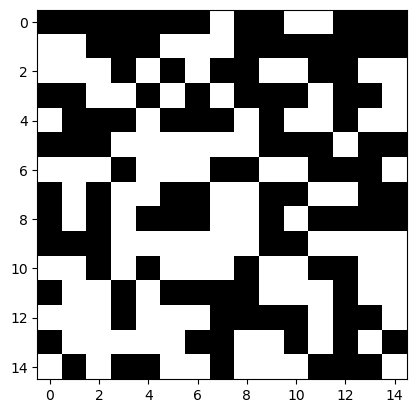

In [50]:
map_size = (15, 15)
grid_map = np.random.randint(2, size=map_size)
plt.imshow(grid_map, cmap='gray_r')

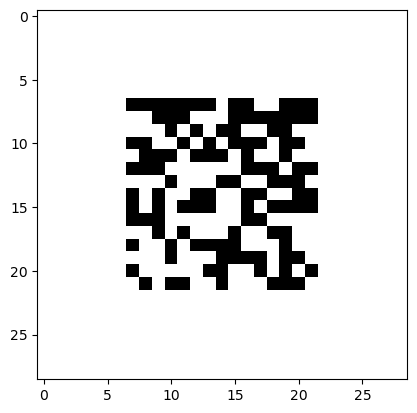

In [51]:
obstacle_map = np.pad(grid_map, obs_radius, 'constant', constant_values=0)
plt.imshow(obstacle_map, cmap='gray_r')

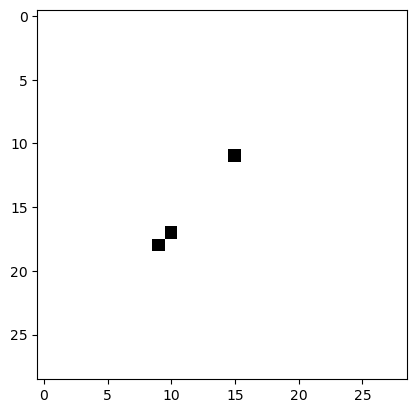

In [52]:
agents_pos = np.random.randint(1, map_size[0]-1, size=(num_agents, 2))
agent_map = np.zeros((map_size), dtype=bool)
agent_map[agents_pos[:,0], agents_pos[:,1]] = 1
agent_map = np.pad(agent_map, obs_radius, 'constant', constant_values=0)
plt.imshow(agent_map, cmap='gray_r')

In [53]:
# 1. neighboring agents
# 2. obstacle_map
# 3. heuri_map

for i, agent_pos in enumerate(agents_pos):
    x, y = agent_pos
    obs[i, 0] = agent_map[x:x+2*obs_radius+1, y:y+2*obs_radius+1]
    obs[i, 0, obs_radius, obs_radius] = 0
    obs[i, 1] = obstacle_map[x:x+2*obs_radius+1, y:y+2*obs_radius+1]
    # obs[i, 2:] = heuri_map[i, :, x:x+2*obs_radius+1, y:y+2*obs_radius+1]

In [54]:
agents_pos[0]

array([4, 8])

In [57]:
plt.imshow(obs[0,1], cmap='gray_r')